In [ ]:
# Install required packages
%pip install sentence-transformers langchain-core langchain-community langchain-text-splitters
%pip install langchain-huggingface faiss-cpu rank_bm25 pypdf numpy nltk matplotlib


In [1]:
import glob
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# Setup for Google Colab (remove if running locally)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SciPy')
except ImportError:
    pass

from Modules.scipy_retriever_helper import ScipyRetrieverHelper


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Configuration
NUM_DOCUMENTS = 100
CHUNK_SIZE = 2000
CHUNK_OVERLAP = 100

print(f"Configuration:")
print(f"   Documents: {NUM_DOCUMENTS}")
print(f"   Chunk size: {CHUNK_SIZE}")
print(f"   Overlap: {CHUNK_OVERLAP}")


Configuration:
   Documents: 100
   Chunk size: 2000
   Overlap: 100


In [10]:
# Load documents
folder_path = 'Data/selected_files_scipy'
txt_files = glob.glob(os.path.join(folder_path, '*.txt'))[:NUM_DOCUMENTS]
print(f"Found {len(txt_files)} text files")

documents_dict = {}
for fp in txt_files:
    try:
        with open(fp, 'r', encoding='utf-8') as f:
            documents_dict[os.path.basename(fp)] = f.read()
    except Exception as e:
        print(f"Error reading {fp}: {e}")

print(f"Successfully loaded {len(documents_dict)} documents")


Found 100 text files
Successfully loaded 100 documents


In [11]:
# Create chunks
docs = [
    Document(page_content=content, metadata={"source": filename})
    for filename, content in documents_dict.items()
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)
texts = text_splitter.split_documents(docs)

chunks = []
for i, text in enumerate(texts):
    chunk_dict = {
        "content": text.page_content,
        "metadata": {
            **text.metadata,
            "chunk_id": i
        }
    }
    chunks.append(chunk_dict)

print(f"Created {len(chunks)} chunks from {len(docs)} documents")
print(f"Average chunks per document: {len(chunks)/len(docs):.1f}")


Created 2683 chunks from 100 documents
Average chunks per document: 26.8


In [12]:
# Initialize retriever and add documents
retriever = ScipyRetrieverHelper()
retriever.add_documents(chunks)

# Initialize sparse retriever with timing analysis
sparse_stats = retriever.initialize_sparse(return_stats=True)

print(f"Sparse (BM25) Analysis:")
print(f"   Total time: {sparse_stats['total_time']:.3f}s")
print(f"   Avg chunk time: {sparse_stats['avg_chunk_time']:.2f}ms")
print(f"   Min chunk time: {sparse_stats['min_chunk_time']:.2f}ms")
print(f"   Max chunk time: {sparse_stats['max_chunk_time']:.2f}ms")


Analyzing sparse (BM25) incremental chunk timing...


Adding chunks to BM25: 100%|██████████| 2683/2683 [03:35<00:00, 12.45it/s]

Sparse analysis complete! 2683 chunk times recorded.
Sparse (BM25) Analysis:
   Total time: 215.560s
   Avg chunk time: 79.58ms
   Min chunk time: 0.38ms
   Max chunk time: 781.32ms


In [13]:
# Initialize dense retriever with timing analysis
dense_stats = retriever.initialize_dense(return_stats=True)

print(f"Dense (FAISS) Analysis:")
print(f"   Total time: {dense_stats['total_time']:.3f}s")
print(f"   Model loading: {dense_stats['model_loading_time']:.3f}s")
print(f"   Embedding computation: {dense_stats['embedding_computation_time']:.3f}s")
print(f"   Avg chunk time: {dense_stats['avg_chunk_time']:.2f}ms")
print(f"   Min chunk time: {dense_stats['min_chunk_time']:.2f}ms")
print(f"   Max chunk time: {dense_stats['max_chunk_time']:.2f}ms")
print(f"   GPU used: {dense_stats['gpu_used']}")


Analyzing dense (FAISS) incremental chunk timing...


Adding chunks to FAISS: 100%|██████████| 2683/2683 [00:23<00:00, 112.09it/s]

Dense analysis complete! 2683 chunk times recorded.
Dense (FAISS) Analysis:
   Total time: 26.870s
   Model loading: 2.932s
   Embedding computation: 23.938s
   Avg chunk time: 8.84ms
   Min chunk time: 6.16ms
   Max chunk time: 56.44ms
   GPU used: False


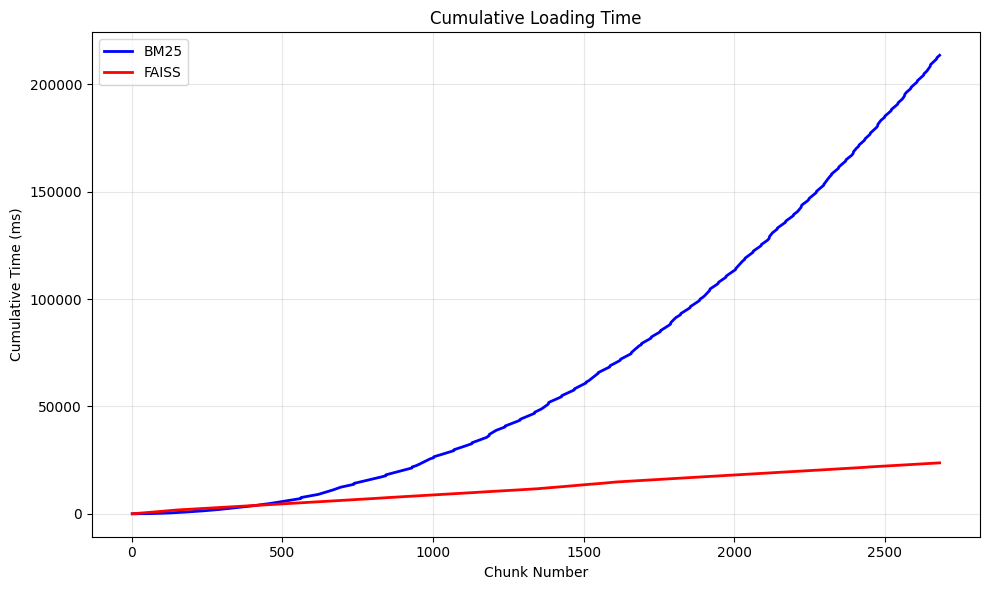

In [18]:
# Visualize chunk loading times
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

chunk_numbers = list(range(1, len(sparse_stats['chunk_times']) + 1))

# Cumulative time comparison
sparse_cumulative = np.cumsum(sparse_stats['chunk_times'])
dense_cumulative = np.cumsum(dense_stats['chunk_times'])

ax.plot(chunk_numbers, sparse_cumulative, 'b-', linewidth=2, label='BM25')
ax.plot(chunk_numbers, dense_cumulative, 'r-', linewidth=2, label='FAISS')
ax.set_xlabel('Chunk Number')
ax.set_ylabel('Cumulative Time (ms)')
ax.set_title('Cumulative Loading Time')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [22]:
# Test queries for runtime analysis
test_queries = [
    "What is Machine Learning?"
]

query_results = []

print("Query Runtime Analysis with Top 3 Results:")
print("=" * 80)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 60)

    # Get sparse results
    sparse_docs, sparse_time = retriever.retrieve_sparse(query, top_k=3)

    # Get dense results
    dense_docs, dense_time = retriever.retrieve_dense(query, top_k=3)

    query_results.append({
        'query': query,
        'sparse_time': sparse_time,
        'dense_time': dense_time,
        'sparse_docs': sparse_docs,
        'dense_docs': dense_docs
    })

    print(f"Timing: Sparse {sparse_time:.2f}ms | Dense {dense_time:.2f}ms")
    print()

    # Display Sparse Results
    print("SPARSE (BM25) - Top 3 Results:")
    for i, doc in enumerate(sparse_docs, 1):
        content_preview = doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
        source = doc.metadata.get('source', 'Unknown')
        chunk_id = doc.metadata.get('chunk_id', 'N/A')

        print(f"  {i}. Source: {source} | Chunk ID: {chunk_id}")
        print(f"     Content: {content_preview}")
        print()

    # Display Dense Results
    print("DENSE (FAISS) - Top 3 Results:")
    for i, doc in enumerate(dense_docs, 1):
        content_preview = doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
        source = doc.metadata.get('source', 'Unknown')
        chunk_id = doc.metadata.get('chunk_id', 'N/A')

        print(f"  {i}. Source: {source} | Chunk ID: {chunk_id}")
        print(f"     Content: {content_preview}")
        print()

    print("=" * 80)

Query Runtime Analysis with Top 3 Results:

Query: 'What is Machine Learning?'
------------------------------------------------------------
Timing: Sparse 7.08ms | Dense 9.30ms

SPARSE (BM25) - Top 3 Results:
  1. Source: 2311.04402v1.txt | Chunk ID: 0
     Content: One of the main issues addressed by machine learning and statistics is the estimation of an unknown model from noisy observations. For example, in supervised learning, this might concern learning the dependence between an input (covariate) x𝑥x and a random variable (observation) y𝑦y. In many cases, we are not only interested in an estimate θ^^𝜃{\hat{{\theta}}} of the true model parameter θ⋆subscript𝜃⋆{\theta_{\star}}, but instead in a set of plausible values that θ⋆subscript𝜃⋆{\theta_{\star}} could take. Such confidence sets are of tremendous importance in sequential decision-making tasks, where uncertainty is used to drive exploration or risk-aversion needs to be implemented, and covariates are iteratively chosen based on 